
# Retail Customer Insights – Full Analysis Notebook

This notebook implements **Question 2** of Exam

> A UK retailer needs insights into customer purchasing behavior. i will perfom:
> clustering, deep embedding analysis, and association rule mining to generate
> actionable marketing recommendations.

The notebook is organized as:

- Part A – Data Cleaning and Classical Clustering  
- Part B – Deep Embedding (Autoencoder) Clustering  
- Part C – Association Rule Mining  
- Part D – Interpretation and Business Insights (Markdown)


## Setup and Imports

In [1]:

import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 6)

DATA_DIR = Path('../data')
print('Using data directory:', DATA_DIR.resolve())


Using data directory: C:\Users\Dell\Desktop\Group_2\retail_customer_insights\data


## Load Dataset and Auto-Detect Column Names

In [2]:

# Adjust filename here if your CSV has a different name
csv_path = DATA_DIR / 'online_retail_II.csv'
print('CSV path:', csv_path.resolve())

retail_df = pd.read_csv(csv_path, encoding='unicode_escape')
print("Raw columns:", retail_df.columns.tolist())

cols = retail_df.columns

# Invoice column
if 'InvoiceNo' in cols:
    invoice_col = 'InvoiceNo'
elif 'Invoice' in cols:
    invoice_col = 'Invoice'
else:
    raise ValueError("Could not find an invoice column (InvoiceNo or Invoice).")

# Customer column
if 'CustomerID' in cols:
    customer_col = 'CustomerID'
elif 'Customer ID' in cols:
    customer_col = 'Customer ID'
else:
    raise ValueError("Could not find a customer column (CustomerID or Customer ID).")

# Price column
if 'UnitPrice' in cols:
    price_col = 'UnitPrice'
elif 'Price' in cols:
    price_col = 'Price'
else:
    raise ValueError("Could not find a price column (UnitPrice or Price).")

print("Using column mapping:")
print(" invoice_col :", invoice_col)
print(" customer_col:", customer_col)
print(" price_col   :", price_col)

retail_df.head()


CSV path: C:\Users\Dell\Desktop\Group_2\retail_customer_insights\data\online_retail_II.csv
Raw columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
Using column mapping:
 invoice_col : Invoice
 customer_col: Customer ID
 price_col   : Price


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Part A – Data Cleaning


Following the question instructions:

1. I will remove missing descriptions  
2. I will remove negative quantities  
3. I will remove cancelled invoices (Invoice starting with 'C')  
4. Drop missing customer IDs  
5. Restrict to UK customers


In [3]:

print('Original shape:', retail_df.shape)
print('Missing ratio by column:')
print(retail_df.isna().mean())

# 1) Remove missing descriptions
retail_df = retail_df.dropna(subset=['Description'])

# 2) Remove negative quantities
retail_df = retail_df[retail_df['Quantity'] > 0]

# 3) Remove cancelled invoices
retail_df[invoice_col] = retail_df[invoice_col].astype(str)
retail_df = retail_df[~retail_df[invoice_col].str.startswith('C')]

# 4) Remove missing customers
retail_df = retail_df.dropna(subset=[customer_col])
retail_df[customer_col] = retail_df[customer_col].astype(str)

# 5) Restrict to UK if Country column present
if 'Country' in retail_df.columns:
    before = len(retail_df)
    retail_df = retail_df[retail_df['Country'] == 'United Kingdom']
    print("Kept UK rows:", len(retail_df), "of", before)

print('After cleaning:', retail_df.shape)
retail_df.head()


Original shape: (1067371, 8)
Missing ratio by column:
Invoice        0.000000
StockCode      0.000000
Description    0.004105
Quantity       0.000000
InvoiceDate    0.000000
Price          0.000000
Customer ID    0.227669
Country        0.000000
dtype: float64
Kept UK rows: 725296 of 805620
After cleaning: (725296, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Part A – Customer-Level Feature Engineering


Here i aggregate by `customer_col` to build features:

- total_spent = sum(Quantity * price_col)  
- num_invoices = number of unique invoices per customer  
- total_quantity = sum of Quantity  
- avg_basket_size = total_quantity / num_invoices  
- avg_order_value = total_spent / num_invoices


In [4]:

# Monetary value per line
retail_df['LineTotal'] = retail_df['Quantity'] * retail_df[price_col]

group = retail_df.groupby(customer_col)

customer_features = pd.DataFrame({
    'total_spent': group['LineTotal'].sum(),
    'num_invoices': group[invoice_col].nunique(),
    'total_quantity': group['Quantity'].sum(),
})

customer_features['avg_basket_size'] = (
    customer_features['total_quantity'] / customer_features['num_invoices']
)
customer_features['avg_order_value'] = (
    customer_features['total_spent'] / customer_features['num_invoices']
)

print("Customer-level feature shape:", customer_features.shape)
customer_features.head()


Customer-level feature shape: (5353, 5)


,total_spent,num_invoices,total_quantity,avg_basket_size,avg_order_value
Customer ID,,,,,
12346.0,77556.46,12,74285,6190.416667,6463.038333
12608.0,415.79,1,323,323.000000,415.790000
12745.0,723.85,2,467,233.500000,361.925000
12746.0,254.55,1,97,97.000000,254.550000
12747.0,9276.54,26,2758,106.076923,356.790000


### Scale Features for Clustering

In [5]:

feature_cols = ['total_spent', 'num_invoices', 'total_quantity',
                'avg_basket_size', 'avg_order_value']

X = customer_features[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix shape:", X_scaled.shape)
X_scaled[:5]


Scaled feature matrix shape: (5353, 5)


array([[ 6.19453629e+00,  4.77893157e-01,  1.13461207e+01,
         4.36429570e+00,  4.89670651e+00],
       [-1.93328351e-01, -4.39010811e-01, -2.03911779e-01,
         6.50046954e-02,  4.05396791e-02],
       [-1.67818519e-01, -3.55655905e-01, -1.81424492e-01,
        -5.75536347e-04, -2.71593264e-03],
       [-2.06680313e-01, -4.39010811e-01, -2.39204326e-01,
        -1.00594549e-01, -8.89420779e-02],
       [ 5.40412640e-01,  1.64486184e+00,  1.76341987e-01,
        -9.39435242e-02, -6.83952990e-03]])

### k-Means Clustering – Silhouette Scores

k=2, silhouette=0.9606
k=3, silhouette=0.9534
k=4, silhouette=0.9534
k=5, silhouette=0.9425
k=6, silhouette=0.7662


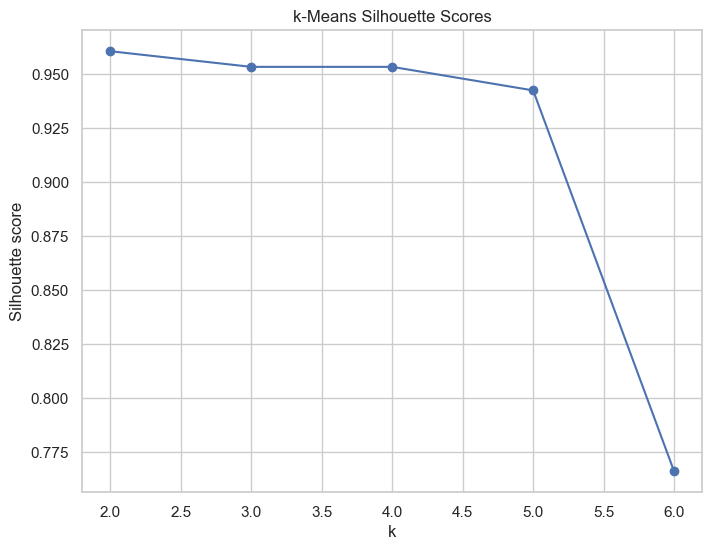

In [6]:

k_values = [2, 3, 4, 5, 6]
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f'k={k}, silhouette={score:.4f}')

plt.figure()
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('k-Means Silhouette Scores')
plt.show()


### Fit Final k-Means Model

In [7]:

# TODO: After inspecting the silhouette plot above, adjust BEST_K if needed
BEST_K = 4

kmeans = KMeans(n_clusters=BEST_K, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_scaled)

customer_features['cluster_kmeans'] = kmeans_labels

# Cluster summary statistics
customer_features.groupby('cluster_kmeans')[feature_cols].mean()


,total_spent,num_invoices,total_quantity,avg_basket_size,avg_order_value
cluster_kmeans,,,,,
0,2182.762882,5.787498,1270.928478,205.543461,341.404495
1,121467.345917,113.041667,74184.291667,1313.939215,1696.247240
2,11880.840000,1.000000,87167.000000,87167.000000,11880.840000
3,168472.500000,2.000000,80997.000000,40498.500000,84236.250000


### DBSCAN Clustering (with Safe Silhouette Handling)

In [8]:

dbscan = DBSCAN(eps=1.5, min_samples=10)
db_labels = dbscan.fit_predict(X_scaled)
customer_features['cluster_dbscan'] = db_labels

unique, counts = np.unique(db_labels, return_counts=True)
print("DBSCAN label counts (label: count):")
for u, c in zip(unique, counts):
    print(f"  {u}: {c}")

# Compute silhouette only if there are >= 2 clusters after removing noise
mask = db_labels != -1
core_labels = db_labels[mask]

if mask.sum() == 0:
    print("All points are noise -> no silhouette score.")
elif len(np.unique(core_labels)) < 2:
    print("Only one non-noise cluster -> silhouette undefined.")
else:
    sil_db = silhouette_score(X_scaled[mask], core_labels)
    print("DBSCAN silhouette (excluding noise):", sil_db)


DBSCAN label counts (label: count):
  -1: 50
  0: 5303
Only one non-noise cluster -> silhouette undefined.


### PCA Visualization of k-Means Clusters

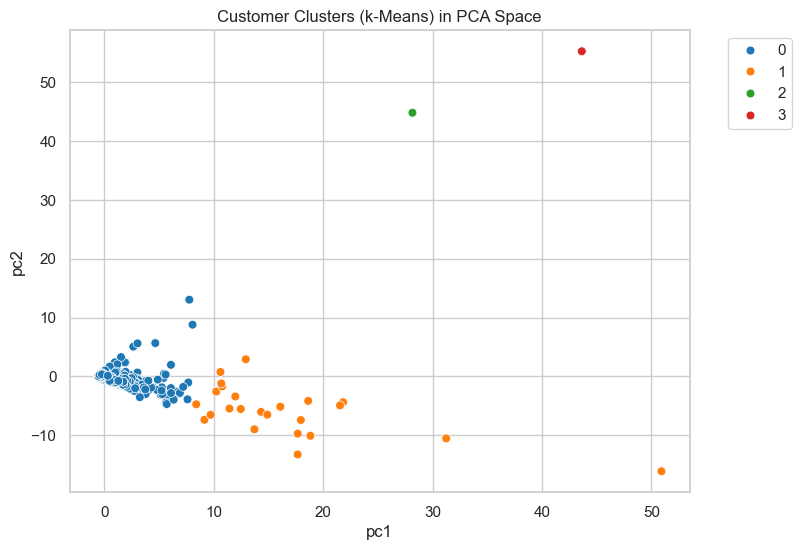

In [9]:

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

customer_features['pc1'] = X_pca[:, 0]
customer_features['pc2'] = X_pca[:, 1]

plt.figure()
sns.scatterplot(
    data=customer_features,
    x='pc1', y='pc2',
    hue='cluster_kmeans',
    palette='tab10',
    s=40
)
plt.title('Customer Clusters (k-Means) in PCA Space')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Part B – Deep Embedding Clustering (Autoencoder)


We train an autoencoder on the scaled customer feature vectors:

- Encoder compresses to a low-dimensional latent representation  
- Decoder reconstructs the original features  
- We then cluster in latent space with k-Means and compare to PCA-based clusters


In [10]:

from tensorflow.keras import layers, models

input_dim = X_scaled.shape[1]
latent_dim = 2  # you can increase if you want higher-dimensional embedding

inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(8, activation='relu')(inputs)
latent = layers.Dense(latent_dim, activation='relu')(x)
x = layers.Dense(8, activation='relu')(latent)
outputs = layers.Dense(input_dim, activation='linear')(x)

autoencoder = models.Model(inputs, outputs)
encoder = models.Model(inputs, latent)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135 (540.00 B)

 Trainable params: 135 (540.00 B)

 Non-trainable params: 0 (0.00 B)

### Train the autoencoder
This cell trains the autoencoder on the scaled customer feature vectors and stores the training history for plotting the loss curve.

Epoch 1/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.9318 - val_loss: 1.3403
Epoch 2/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8883 - val_loss: 1.3142
Epoch 3/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8562 - val_loss: 1.2957
Epoch 4/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8262 - val_loss: 1.2785
Epoch 5/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7970 - val_loss: 1.2639
Epoch 6/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7658 - val_loss: 1.2482
Epoch 7/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7349 - val_loss: 1.2332
Epoch 8/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7028 - val_loss: 1.2191
Epoch 9/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6681 - val_loss: 1.2059
Epoch 10/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6378 - val_loss: 1.1934
Epoch 11/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6023 - val_loss: 1.1821
Epoch 12/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5690 - v

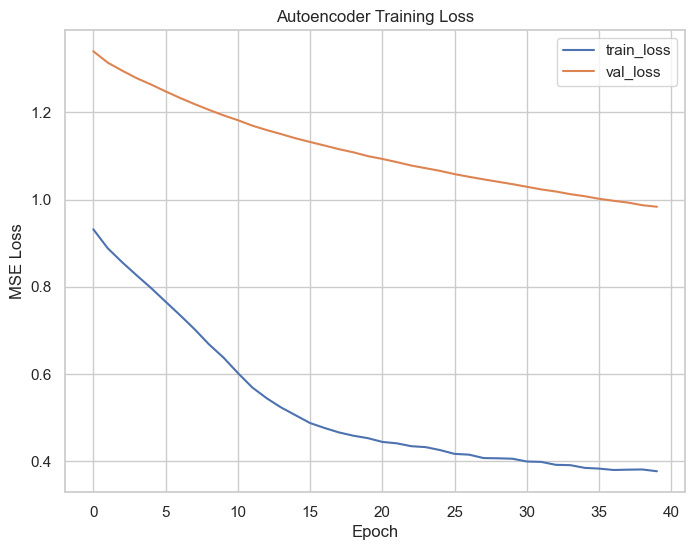

In [11]:

history_ae = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=40,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

plt.figure()
plt.plot(history_ae.history['loss'], label='train_loss')
plt.plot(history_ae.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.show()


### Cluster Latent Embeddings

168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Latent embedding shape: (5353, 2)
Silhouette score (autoencoder latent, k-Means): 0.43184468150138855


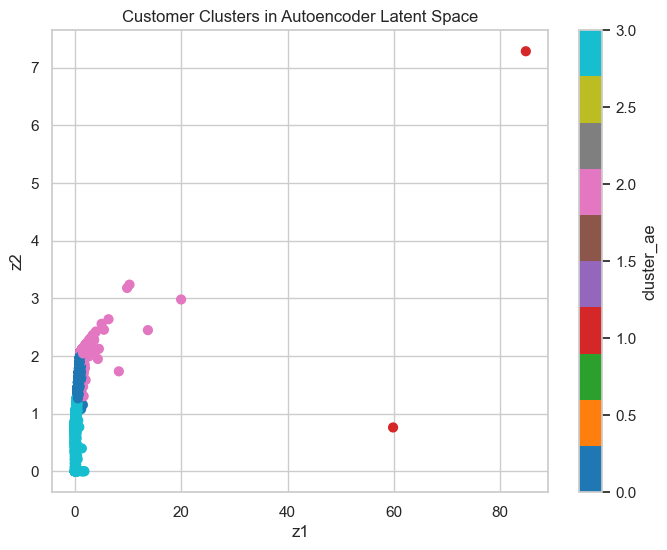

In [12]:

latent_embeddings = encoder.predict(X_scaled)
print("Latent embedding shape:", latent_embeddings.shape)

kmeans_ae = KMeans(n_clusters=BEST_K, random_state=42, n_init='auto')
ae_labels = kmeans_ae.fit_predict(latent_embeddings)

customer_features['cluster_ae'] = ae_labels

sil_ae = silhouette_score(latent_embeddings, ae_labels)
print("Silhouette score (autoencoder latent, k-Means):", sil_ae)

plt.figure()
plt.scatter(latent_embeddings[:, 0], latent_embeddings[:, 1],
            c=ae_labels, cmap='tab10', s=40)
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Customer Clusters in Autoencoder Latent Space')
plt.colorbar(label='cluster_ae')
plt.show()


## Part C – Association Rule Mining


We now analyze product co-occurrences to support cross-selling and marketing.

Steps:

1. Convert transactions to baskets: invoice -> list of Description  
2. Restrict to frequent items to keep matrix manageable  
3. Build a binary transaction-item matrix  
4. Apply Apriori and generate association rules sorted by lift


In [13]:

from mlxtend.preprocessing import TransactionEncoder

# Build baskets
basket_series = retail_df.groupby(invoice_col)['Description'].apply(list)
transactions = basket_series.tolist()

# Compute item frequencies
item_counts = pd.Series([item for basket in transactions for item in basket]).value_counts()

# Keep items that appear at least this many times
MIN_ITEM_FREQ = 50
frequent_items = set(item_counts[item_counts >= MIN_ITEM_FREQ].index)
print("Number of frequent items kept:", len(frequent_items))

filtered_transactions = [
    [item for item in basket if item in frequent_items]
    for basket in transactions
]

te = TransactionEncoder()
te_ary = te.fit(filtered_transactions).transform(filtered_transactions)
basket_matrix = pd.DataFrame(te_ary, columns=te.columns_)

basket_matrix.head()


Number of frequent items kept: 2698


,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,RED/WHITE DOT MINI CASES,SET 2 TEA TOWELS I LOVE LONDON,...,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Mine frequent itemsets and set up association rules
This cell imports Apriori/association rule utilities and prepares to compute frequent itemsets and rules.

In [14]:

from mlxtend.frequent_patterns import apriori, association_rules

freq_itemsets = apriori(
    basket_matrix,
    min_support=0.01,   # adjust if too many/few results
    use_colnames=True
)

print("Number of frequent itemsets:", len(freq_itemsets))
freq_itemsets.sort_values('support', ascending=False).head()


Number of frequent itemsets: 710


,support,itemsets
500,0.140136,(WHITE HANGING HEART T-LIGHT HOLDER)
382,0.085137,(REGENCY CAKESTAND 3 TIER)
30,0.074644,(ASSORTED COLOUR BIRD ORNAMENT)
219,0.071275,(JUMBO BAG RED RETROSPOT)
316,0.057891,(PARTY BUNTING)


### Generate and rank association rules
This cell generates association rules from frequent itemsets and sorts them (e.g., by lift) to extract the strongest co-purchase relationships.

In [15]:

rules = association_rules(freq_itemsets, metric='lift', min_threshold=1.0)
print("Number of rules:", len(rules))

rules_sorted = rules.sort_values('lift', ascending=False).head(10)
rules_sorted


Number of rules: 402


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
295,(POPPY'S PLAYHOUSE LIVINGROOM ),(POPPY'S PLAYHOUSE KITCHEN),0.011715,0.015829,0.010463,0.893130,56.423599,1.0,0.010278,9.209029,0.993921,0.612565,0.891411,0.777073
294,(POPPY'S PLAYHOUSE KITCHEN),(POPPY'S PLAYHOUSE LIVINGROOM ),0.015829,0.011715,0.010463,0.661017,56.423599,1.0,0.010278,2.915440,0.998075,0.612565,0.656999,0.777073
293,(POPPY'S PLAYHOUSE BEDROOM ),(POPPY'S PLAYHOUSE KITCHEN),0.014070,0.015829,0.012013,0.853814,53.939792,1.0,0.011791,6.732300,0.995467,0.671667,0.851462,0.806379
292,(POPPY'S PLAYHOUSE KITCHEN),(POPPY'S PLAYHOUSE BEDROOM ),0.015829,0.014070,0.012013,0.758945,53.939792,1.0,0.011791,4.090068,0.997246,0.671667,0.755505,0.806379
307,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.015233,0.013057,0.010106,0.663405,50.809560,1.0,0.009907,2.932140,0.995483,0.555738,0.658952,0.718689
306,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.013057,0.015233,0.010106,0.773973,50.809560,1.0,0.009907,4.356849,0.993288,0.555738,0.770476,0.718689
45,(RED STRIPE CERAMIC DRAWER KNOB),(BLUE STRIPE CERAMIC DRAWER KNOB),0.015769,0.017170,0.010493,0.665406,38.752993,1.0,0.010222,2.937383,0.989804,0.467463,0.659561,0.638259
44,(BLUE STRIPE CERAMIC DRAWER KNOB),(RED STRIPE CERAMIC DRAWER KNOB),0.017170,0.015769,0.010493,0.611111,38.752993,1.0,0.010222,2.530879,0.991215,0.467463,0.604880,0.638259
194,"(KEY FOB , BACK DOOR )","(KEY FOB , SHED)",0.016932,0.019287,0.012282,0.725352,37.608442,1.0,0.011955,3.570801,0.990176,0.513076,0.719951,0.681069
195,"(KEY FOB , SHED)","(KEY FOB , BACK DOOR )",0.019287,0.016932,0.012282,0.636785,37.608442,1.0,0.011955,2.706575,0.992554,0.513076,0.630529,0.681069


## Part D – Interpretation and Presentation (Markdown Only)


In this section, you will interpret your results and write the narrative for your report.

### D.1 Cluster Meanings and Customer Types

Using the summary statistics for `cluster_kmeans` (and optionally `cluster_ae`), describe each cluster:

- What is the typical total spending?  
- How frequently do they purchase (num_invoices)?  
- Do they place large or small baskets (avg_basket_size)?  
- Are they high-value, medium-value, or low-value customers?

Explain in words what kind of customers belong to each cluster (e.g., "loyal heavy spenders", "occasional bargain shoppers", etc.).

---

### D.2 High-Value Segments

Identify which clusters represent your **most valuable segments**, based on:

- Highest `total_spent`  
- Highest `avg_order_value`  
- Reasonable or high `num_invoices`  

Explain why these clusters should be prioritized for marketing, retention, and personalized offers.

---

### D.3 PCA vs Deep Embedding Clusters

Compare:

1. k-Means clusters in **PCA space** (Part A)  
2. k-Means clusters in **autoencoder latent space** (Part B)  

Discuss:

- Which representation gives better-separated clusters visually?  
- Do autoencoder clusters reveal new patterns, such as nonlinear relationships between spend and frequency?  
- Which segmentation is more intuitive from a business perspective?

---

### D.4 Three Actionable Business Recommendations

Based on:

- Customer clustering results, and  
- Association rules (top 10 by lift),

propose at least **three concrete actions**, such as:

1. **Targeted loyalty campaigns** for the high-value cluster(s) (e.g., exclusive discounts, early access to new collections).  
2. **Cross-selling recommendations** using strong rules (e.g., "customers who buy product A also often buy product B", so recommend B whenever A is added to cart).  
3. **Product bundling and merchandising**: bundle items frequently purchased together and feature them as "combo offers" or place them together in-store/online.  
4. **Reactivation campaigns** for low-frequency or low-spend clusters, offering limited-time discounts to encourage repeat purchases.  
5. **Inventory and demand planning**: use frequent itemsets to ensure sufficient stock of items that frequently co-occur, reducing stockouts.

Conclude with a short paragraph summarizing how clustering + deep embeddings + association rules provide a comprehensive view of customer behavior to support data-driven marketing decisions.
